## Project 1: Predicting stroke with Naive Bayes and K-NN

In [680]:
#import
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn
import math

In [681]:
# This function should transform data into a usable format 
def preprocess():
    csvdata = pd.read_csv('stroke_update.csv',header = 0)
    return csvdata

In [682]:
# This function should split a data set into a training set and hold-out test set
#ratio up to 1 e.g.0.8
def split_data(csvdata, trainRatio):
    #Transform numeric attributes to nominal for avg_glucose_level,bmi,age
    csvdata["avg_glucose_level"] = pd.qcut(csvdata["avg_glucose_level"], q=10)
    csvdata["bmi"] = pd.qcut(csvdata["bmi"], q=10)
    csvdata["age"] = pd.qcut(csvdata["age"], q=10)

    csvdata = csvdata.sample(frac=1).reset_index(drop=True)
    dshape = csvdata.shape[0]
    trainRow = int(dshape*trainRatio)
    trainSet = csvdata[0:trainRow]
    testSet = csvdata[trainRow:]
    trainLabel = trainSet.drop(columns=trainSet.columns.difference(['stroke']))
    trainSet = trainSet.drop(columns="stroke")
    testLabel = testSet.drop(columns=testSet.columns.difference(['stroke']))
    testSet = testSet.drop(columns="stroke")
    return trainSet.values.tolist(), testSet.values.tolist(), trainLabel['stroke'].tolist(), testLabel['stroke'].tolist()

In [683]:
# This function should build a supervised NB model
#for native bayes implement from scratch
def train(trainSet, trainLabel):
    #prior
    tl = np.array(trainLabel)
    tl_0 = np.count_nonzero(tl == 0)
    tl_1 = np.count_nonzero(tl == 1)
    prior = [tl_0,tl_1]
    #likelihood
    #set dictionary 
    likelihood = {0:{},1:{}}
    for key in likelihood.keys():
        for column in range(len(trainSet[0])):
            likelihood[key][column]={}
            cldict = set([i[column] for i in trainSet])
            likelihood[key][column] = {j:0 for j in cldict}
    
    #count and push to dictionary
    for i, row in enumerate(trainSet):#use enumerate to get index
        for j, column in enumerate(trainSet[i]):#use enumerate to get index
            likelihood[trainLabel[i]][j][column] += 1

    #likelihood div plus epsilons
    for i in range(0,2):
        for j in likelihood[i].keys():
            for val in likelihood[i][j]:
                if likelihood[i][j][val] > 0:
                    likelihood[i][j][val] = likelihood[i][j][val] / prior[i]
                else:
                    likelihood[i][j][val] = 1/(math.e**10)*len(trainSet)
    return prior, likelihood

In [684]:
# This function should predict the class for an instance or a set of instances, based on a trained model 
# epsilon is smaller value than 1/N where N is the number of trainSet instances
#log prediction
def predict(testSet, prior, likelihood):
    prediction = np.array([])
    #each row of testSet
    for row in testSet:
        priorProbabilityArray = []
        for i in range(len(prior)):
            #prior probability
            priorProbability = math.log(prior[i]/sum(prior))
            for j, f in enumerate(row):
                if f in likelihood[i][j]:
                    priorProbability = priorProbability + math.log(likelihood[i][j][f])
            priorProbabilityArray.append(priorProbability)
        prediction = np.append(prediction, np.argmax([priorProbabilityArray]))
    return prediction

In [685]:
from sklearn import metrics
def evaluate(prediction, testLabel):
    confusion = metrics.confusion_matrix(testLabel, prediction) # Confusion Matrix
    accuracy = metrics.accuracy_score(testLabel, prediction) # Accuracy
    precf1 = metrics.precision_recall_fscore_support(testLabel, prediction) # Precision, Recall and F1-score
    return confusion, accuracy, precf1

In [686]:
#run
trainSet, testSet, trainLabel, testLabel = split_data(preprocess(), 0.8)
prior, likelihood = train(trainSet, trainLabel)
prediction = predict(testSet, prior, likelihood)
print(evaluate(prediction, testLabel))

(array([[379,  69],
       [ 55,  45]]), 0.7737226277372263, (array([0.87327189, 0.39473684]), array([0.84598214, 0.45      ]), array([0.85941043, 0.42056075]), array([448, 100])))


## Questions (you may respond in a cell or cells below):

You should respond to questions 1-4. In question 2 (b) you can choose between two options. A response to a question should take about 100--200 words, and make reference to the data wherever possible.

### Question 1: Data exploration

- a) Explore the data and summarise different aspects of the data. Can you see any interesting characteristic in features, classes or categories? What is the main issue with the data? Considering the issue, how would the Naive Bayes classifier work on this data? Discuss your answer based on the Naive Bayes' formulation.
- b) Is accuracy an appropriate metric to evaluate the models created for this data? Justify your answer. Explain which metric(s) would be more appropriate, and contrast their utility against accuracy. [no programming required]



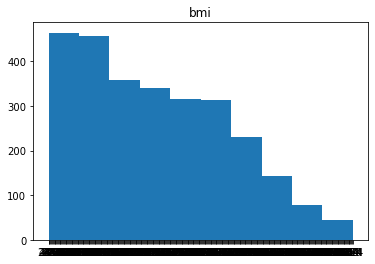

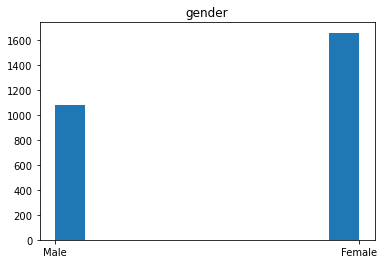

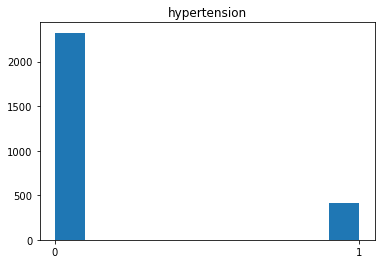

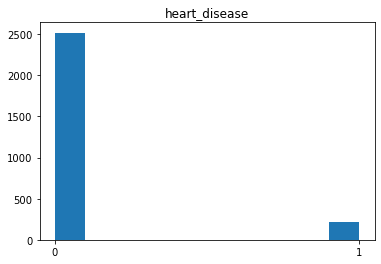

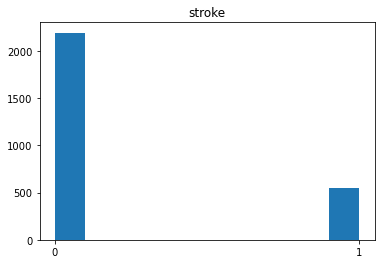

In [687]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
#show imbalance
def graph(csvdata):
    #divide into classes using bin based on range
    csvdata = np.array(csvdata.values.tolist())
    csvdata = np.transpose(csvdata)
    csvdata[0] = csvdata[0].astype(np.float)
    csvdata[1] = csvdata[1].astype(np.float)
    csvdata[2] = csvdata[2].astype(np.float)
    
    plt.title("bmi")
    plt.hist(csvdata[1], bins=10)
    plt.show()
    plt.title("gender")
    plt.hist(csvdata[3])
    plt.show()
    plt.title("hypertension")
    plt.hist(csvdata[4])
    plt.show()
    plt.title("heart_disease")
    plt.hist(csvdata[5])
    plt.show()
    plt.title("stroke")
    plt.hist(csvdata[10])
    plt.show()

graph(preprocess())

a) 
In this data, there are 10 attributes that consists of 3 numeric (avg_glucose_level, bmi, age) and 7 categorical attributes, as well as having 2 classes for the stroke outcomes. Stroke = 1 data appeared in last part of the csv file so data must be shuffled in order to randamise sample. To implement Naive Bayes, each attribute formart, such as numeric, needs to be converted into different data type accordingly. To use categorical naive bayes, numeric can be converted into different classes of range. The main issue of this data is imbalance of each attributes. For example, from graph of stroke, the number of stroke, heart disease, hypertension, gender and others are populated unevenly. This is a problem becasue classification learning algorithm predict based on the training instances and if there is infrequent class, the algorithm is more likely to produce wrong prediction.

b)Accuracy is a metric how often the prediction is correct. High accuracy means that less false positive and false negative. In this data, accuracy works fine because stroke is 2 classes either 0 (no) or 1 (yes). Precision is a metric how the model is good at predicting instances to be interesting. High presicion means that the model does not pick many false positive to be insteresting. Recall is a metric how the model is good at predicting instances without missing interesting instances. High recall means that the model does not pick many false negative; the model doesnt predict insteresting instances as uninsteresting very often. F-score is a metric that combine precision and recall. High F-score would give us low false positive and false negative. It is possible that high precision or high recall, but it is not accurate. F-score and accuracy are related but different usage; when true positive and true negative are important, accuracy can be used but when we cannot accept false negative and false positive, F-score would be suitable. In this data, stroke should not be predicted as false negative or false positive, F-score might be the best option. 

### Question 2: Naive Bayes concepts and formulation

- a) Explain the independence assumption underlying Naive Bayes. What are the advantages and disadvantages of this assumption? Elaborate your answers using the features of the provided data. [no programming required]
- b) Implement the Naive Bayes classifier. You need to decide how you are going to apply Naive Bayes for nominal and numeric attributes. You can combine both Gaussian and Categorical Naive Bayes (option 1) or just using Categorical Naive Bayes (option 2). Explain your decision. For Categorical Naive Bayes, you can choose either epsilon or Laplace smoothing for this calculation. Evaluate the classifier using accuracy and appropriate metric(s) on test data. Explain your observations on how the classifiers have performed based on the metric(s). Discuss the performance of the classifiers in comparison with the Zero-R baseline.
- c) Explain the difference between epsilon and Laplace smoothing. [no programming required]

In [688]:
def ZeroR(prior, testSet):
    if(prior[0]>=prior[1]):
        zeroRprediction = [0]*len(testSet)
    else:
        zeroRprediction = [1]*len(testSet)
    return zeroRprediction

trainSet, testSet, trainLabel, testLabel = split_data(preprocess(), 0.8)
prior, likelihood = train(trainSet, trainLabel)
zeroRprediction = ZeroR(prior, testSet)
evaluate(zeroRprediction, testLabel)

(array([[435,   0],
        [113,   0]]),
 0.7937956204379562,
 (array([0.79379562, 0.        ]),
  array([1., 0.]),
  array([0.88504578, 0.        ]),
  array([435, 113])))

a) The naive assumption made in Naive Bayes is conditional independence assumption that assume given features are independent to each other. This assumption simplifies the expression that use chain rule and conditional probability to simple models with easier product of probability. However, this assumption is not realistic since the dependencies between attributes are likely to exist in real life. Thus, it may not be accurate. For example, the provided data has hypertension and heart disease attributes. They are likely to be related to each other as having hypertension may raise stroke and heart disease as well as heart disease may do the same to stroke and hypertension, so the assumption may work well. 

b) I used catergorical naive bayes and epsilon smoothing for calculation of Naive Bayes. I used bin to divide numeric data into different classes based on quantity of frequency to distribute events evenly. I set epsilon smoothing at 1/(e^10)*N where N is the number of training instances, because epsilon need to be set at less than 1/N to make it very small and if the training instance is larger, 1/(e^10) may not be smaller than 1/N. 
The average accuracy of the native bayes (run 10 times) is at 0.78 when 50%,80% and 90% of data was used for training. 
The confusion matrix shows that [374,74],[47,53] when 80% of data was used for training. 121/548 = 22.08%. It produces 22.08% of Error rate. The F score is [0.85941043,0.42056075] for class 0 and 1. for class 0 it shows 0.86 fscore while for class 1 it show 0.42 fscore.
On the other hand, while zero R produces around 80% of accuracy to predict stroke = 0, when it comes to predict stroke = 1, zero R predicts around 20% of accuracy. The f-score of zero r baseline of class 0 and 1 is calculated as [0.88504578, 0]. Since positive diagnosis is more important in prediction, native bayes performs better predictions than zero R based on accuracy, confusion matrix and f-score metrics.


c)  Both epsilon and laplace smoothing are used to prevent 0 value of probability. As naive bayes use product of probability, if there is any 0 value of possibility, all other meaningful observation will be irrelevant. Epsilon smoothing takes a simple approach to solve this by replacing 0 to the small value which is smaller than 1/N where N is number of training instances to reduce comparisons to the cardinality of it. On the other hand, Laplace smoothing add psudocount to each feature count not to produce 0. However, this may reduce variance of NB classifier and add bias as it reduce sensitivity. Also, when there is few instances, the probability may change a lot. 

### Question 3: Model Comparison
- a) Implement the K-NN classifier, and find the optimal value for K. 
- b) Based on the obtained value for K in question 4 (a), evaluate the classifier using accuracy and chosen metric(s) on test data. Explain your observations on how the classifiers have performed based on the metric(s). Discuss the performance of the classifiers in comparison with the Zero-R baseline.
- c) Compare the classifiers (Naive Bayes and K-NN) based on metrics' results. Provide a comparatory discussion on the results. [no programming required]

[[408  37]
 [ 69  34]] 0.8065693430656934 (array([0.85534591, 0.47887324]), array([0.91685393, 0.33009709]), array([0.88503254, 0.3908046 ]), array([445, 103]))


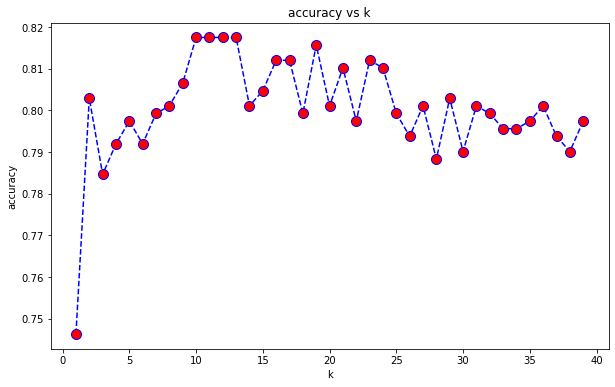

In [766]:
#knn classifier training
#need to optimise kNN (finding the best k) based on some kind of evaluation metric. 
from sklearn.neighbors import KNeighborsClassifier
#set up all data for knn
def knnDataSetup(csvdata):
    #One-hot transformation
    newdata = pd.DataFrame()
    for column in csvdata.columns:
            if column == 'stroke' or column == 'avg_glucose_level' or column == 'bmi' or column == 'age':
                newdata = pd.concat([newdata, csvdata[column]], axis=1)
                continue
            newdata = pd.concat([newdata, pd.get_dummies(csvdata[column], prefix=column, drop_first=True)], axis=1)
    #shuffle data and split
    newdata = newdata.sample(frac=1).reset_index(drop=True)
    dshape = newdata.shape[0]
    trainRow = int(dshape*0.8)
    trainSet = newdata[0:trainRow]
    testSet = newdata[trainRow:].reset_index(drop=True)
    #split label and instances
    trainLabel = trainSet.drop(columns=trainSet.columns.difference(['stroke']))
    train = trainSet.drop(columns="stroke")
    testLabel = testSet.drop(columns=testSet.columns.difference(['stroke']))
    test = testSet.drop(columns="stroke")
    return trainLabel, train, testLabel, test

#return knn prediction
def knnPrediction(trainLabel, train, test, n):
    #training and prediction
    classifier = KNeighborsClassifier(n_neighbors = n)
    classifier.fit(train, trainLabel['stroke'].tolist())
    prediction = classifier.predict(test)
    return prediction

#return optimal value of K
def optimalK(trainLabel, train, testLabel, test):
    #accuracyRate array to store accuracy of each k value
    accuracyRate = []
    for i in range(1,40):
        prediction = knnPrediction(trainLabel, train, test, i)
        confusion, accuracy, precf1 = evaluate(prediction, testLabel['stroke'].tolist())
        accuracyRate.append(accuracy)
    
    #plot to display visual graph
    plt.figure(figsize=(10,6))
    plt.plot(range(1,40),accuracyRate,color = 'blue',linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
    plt.title('accuracy vs k')
    plt.xlabel('k')
    plt.ylabel('accuracy')
    return accuracyRate.index(max(accuracyRate))

#run
csvdata = preprocess()
trainLabel, train, testLabel, test = knnDataSetup(csvdata)
k = optimalK(trainLabel, train, testLabel, test)
prediction = knnPrediction(trainLabel, train, test, k)

confusion, accuracy, precf1 = evaluate(prediction, testLabel['stroke'].tolist())
print (confusion, accuracy, precf1)

a) implemented above. Use for loop to find highest accuracy by changing K value. optimalK function will output the optimal value of K and graph to visually see how accurate it is. 

b) The knn gives [408,37][69,34] of confusion matrix. The accuracy is 0.8065693430656934 = 80.66%, meaning that 105/548 = 0.191605... = 19.16% of error rate (false positive and false negative). the precision was [0.91685393, 0.33009709] and the recall was [0.88503254, 0.3908046 ]. the f score was [0.88503254, 0.3908046]. while zero R produces around 80% of accuracy to predict stroke = 0, when it predict stroke = 1, zero R predicts around 20% of accuracy. The f-score of zero r is [0.88504578,0]. It is obvious that the most important function is to detect stroke = 1, and 20% of zero-r baseline's accuracy is way too low than knn accuracy 80%. Also, zero r shows 0 for f-score of class 1, which is lower than knn's fscore of class 1 that is 0.39. Thus, knn performs better in comparison to zero-r.

c) Based on the result of naive bayes from the question 2, the confusion matrix is [379,69],[55,45], the accuracy is 0.7737226277372263 = 77.37%, the precision = [0.87327189,0.39473684], the recall = [0.84598214,0.45] and fscore is [0.85941043,0.42056075]. Looking at the result from the question 3, the accuracy of the naive bayes is lower than the knn's and the error rate of the naive bayes is higher than knn's based on this result. However, when looking at f-score of both naive bayes and knn, while knn's f-score of class 0 is higher than naive bayes, naive bayes's f-score of class 1 is better than knn's. In this algorithm, positive diagnosis is more important and false positive/false negative should be minimised. Thus, naive bayes is preferable algorithm in this data based on the result on my environment.